## Data Load & Characteristics

- Load time series data and look at its characteristics
- Determine autocorrelation, seasonality, stationarity
- Decomposition, 
- OLS Regression 


In [2]:
# Libraries
#

import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import OLS, add_constant
from statsmodels.stats.stattools import durbin_watson

import matplotlib.pyplot as plt
plt.style.use('ggplot') 
from pandas.plotting import lag_plot


In [3]:
# Establish valid data file path, for reading and saving eg CSV files
#

import os
data_directory = 'Data_Sources'          # Designated data folder above the current working directory
project_directory = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(project_directory, data_directory)
if not os.path.isdir(DATA_PATH):
    raise Exception(f'Directory not found: {DATA_PATH}')

del data_directory, project_directory

In [4]:
# A simple utility function to obtain and summarise key elements of a given dataframe

def print_file_summary(data_frame):
    # Create a temporary df and ensure no lists remain, so that unique items can be identified for uniqueness
    temp_df = data_frame.copy()
    temp_df = temp_df.map(lambda cell: str(cell) if isinstance(cell, list) else cell)
    
    # Calculate Data Types 
    summary_of_df = pd.DataFrame({'Count': data_frame.count(),
                                 'Missing': data_frame.isnull().sum(), 'Empty': 0,
                                 'Unique': temp_df.nunique(),
                                 'Type': data_frame.dtypes, 
                                 'String': 0, 'Int': 0, 'Float': 0, 'List': 0
                                 })
    summary_of_df['Empty'] = (data_frame == '').sum()
    summary_of_df['String'] = data_frame.map(lambda cell: isinstance(cell, str)).sum()
    summary_of_df['Int'] = data_frame.map(lambda cell: isinstance(cell, int)).sum()
    summary_of_df['Float'] = data_frame.map(lambda cell: isinstance(cell, float)).sum()
    summary_of_df['List'] = data_frame.map(lambda cell: isinstance(cell, list)).sum()

    display(summary_of_df)

### Characteristics


In [5]:
# Load the time series CSV

# Load the states .csv file, exit if do not exist or are invalid
file_name = 'hotel_timeseries.csv'
file_path = os.path.join(DATA_PATH, file_name)
if not os.path.isfile(file_path):
    raise Exception(f'File not found: {file_path}')
hotel_time_series_df = pd.read_csv(file_path, parse_dates=['Date'])
hotel_time_series_df.set_index('Date', inplace=True)

# Look at the data file 
# display(f'Summary of the Loaded File: {file_name}')
# display(hotel_time_series_df.head(3))
# print_file_summary(hotel_time_series_df)

# Tidy Up
del file_name, file_path


In [8]:
#| label: csv_file_types
#| tbl-cap: Loaded File Data Types

print_file_summary(hotel_time_series_df)


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
Standard_OCC,1461,0,0,177,int64,0,1461,0,0
Standard_Capacity,1461,0,0,1,int64,0,1461,0,0
Standard_Rate,1461,0,0,1,int64,0,1461,0,0
Premium_OCC,1461,0,0,101,int64,0,1461,0,0
Premium_Capacity,1461,0,0,1,int64,0,1461,0,0
Premium_Rate,1461,0,0,1,int64,0,1461,0,0


In [12]:
#| label: csv_file_summary

print(hotel_time_series_df.head(3))
#display(hotel_time_series_df.head(3))



            Standard_OCC  Standard_Capacity  Standard_Rate  Premium_OCC  \
Date                                                                      
2020-01-01           129                254            325           65   
2020-01-02           126                254            325           53   
2020-01-03           137                254            325           63   

            Premium_Capacity  Premium_Rate  
Date                                        
2020-01-01               100           575  
2020-01-02               100           575  
2020-01-03               100           575  


In [28]:
#| label: csv_file_stats
#| tbl-cap: Loaded File Characteristics

#print(hotel_time_series_df.describe())
display(hotel_time_series_df.describe().T.style.format("{:.2f}"))


,count,mean,std,min,25%,50%,75%,max
Standard_OCC,1461.00,135.65,50.22,38.00,88.00,136.00,183.00,254.00
Standard_Capacity,1461.00,254.00,0.00,254.00,254.00,254.00,254.00,254.00
Standard_Rate,1461.00,325.00,0.00,325.00,325.00,325.00,325.00,325.00
Premium_OCC,1461.00,56.14,29.35,0.00,31.00,57.00,83.00,100.00
Premium_Capacity,1461.00,100.00,0.00,100.00,100.00,100.00,100.00,100.00
Premium_Rate,1461.00,575.00,0.00,575.00,575.00,575.00,575.00,575.00


### Autocorrelation, Seasonality, Stationarity

- Determine autocorrelation, seasonality, stationarity .. lag plot, ACF plot, ADF test, Differencing
- Decomposition

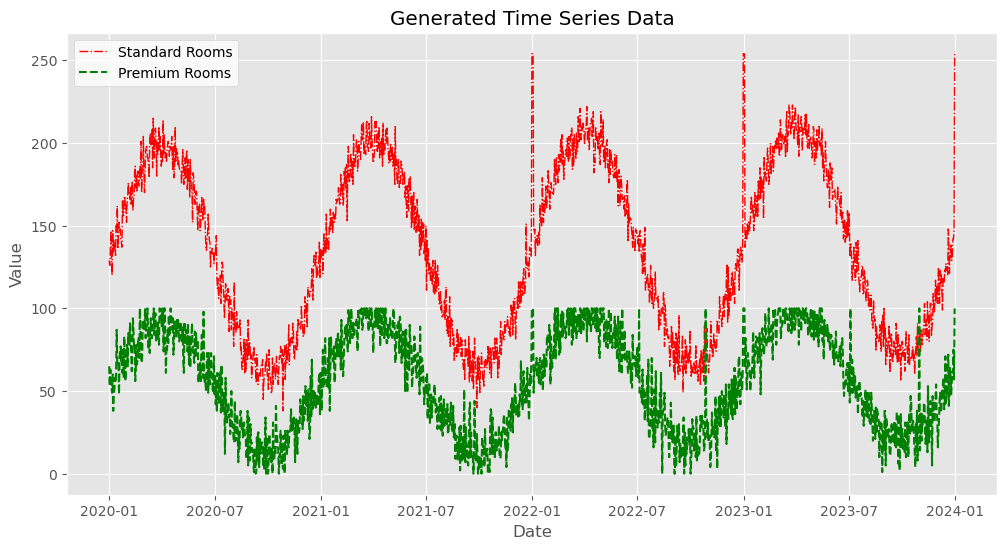

In [10]:
#| label: generated_time_series
#| fig-cap: Occupancy for Each Room Category

# Plot the occupancy time series data
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title(f'Generated Time Series Data')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
# Two line plots
ax.plot(hotel_time_series_df.index, hotel_time_series_df['Standard_OCC'], linestyle='-.', color='red', linewidth=1, label='Standard Rooms')
ax.plot(hotel_time_series_df.index, hotel_time_series_df['Premium_OCC'], 'g--', label='Premium Rooms')
# Legend
ax.legend(loc='upper left', facecolor='white')
plt.show()


- Shows definite annual seasonality with peak high and low seasons
- Also some infrequent spikes in bookings
- Possibly a small upward tend over time
- Premium rooms hit max and zero bookings several times ...

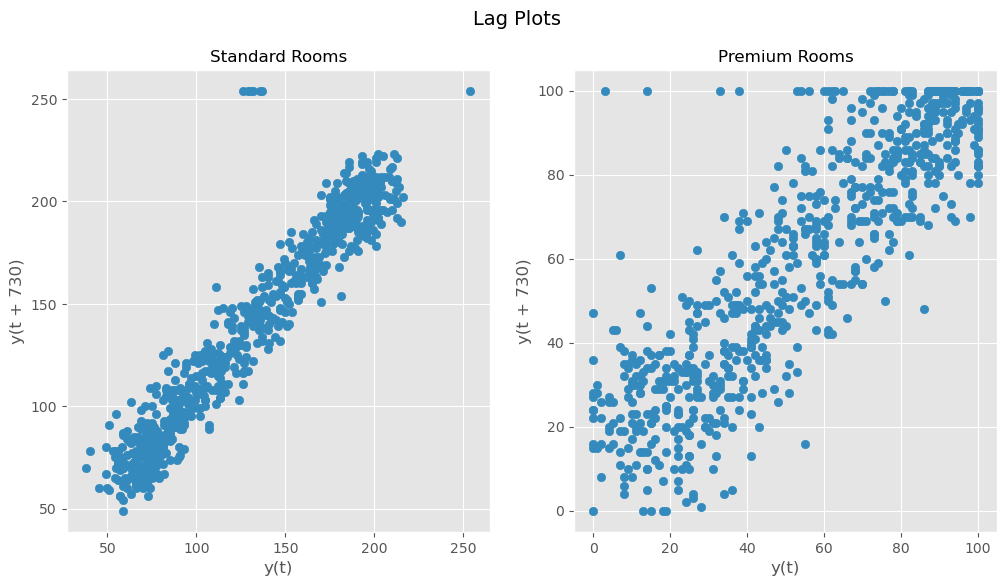

In [11]:
#| label: lag_plots
#| fig-cap: Lag Plots - Test

# Lag plot - is there evidence of autocorrelation?

lag_value = 730

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Lag Plots', fontsize=14)

ax1.set_title('Standard Rooms', fontsize=12)
lag_plot(hotel_time_series_df['Standard_OCC'], lag=lag_value, ax=ax1)
ax2.set_title('Premium Rooms', fontsize=12)
lag_plot(hotel_time_series_df['Premium_OCC'], lag=lag_value, ax=ax2)

plt.show()



- Both categories of room show definite autocorrelation 
- Premium rooms bunched up at max value and autocorrelation may be slight less strong
- Some outliers when rooms are fully booked

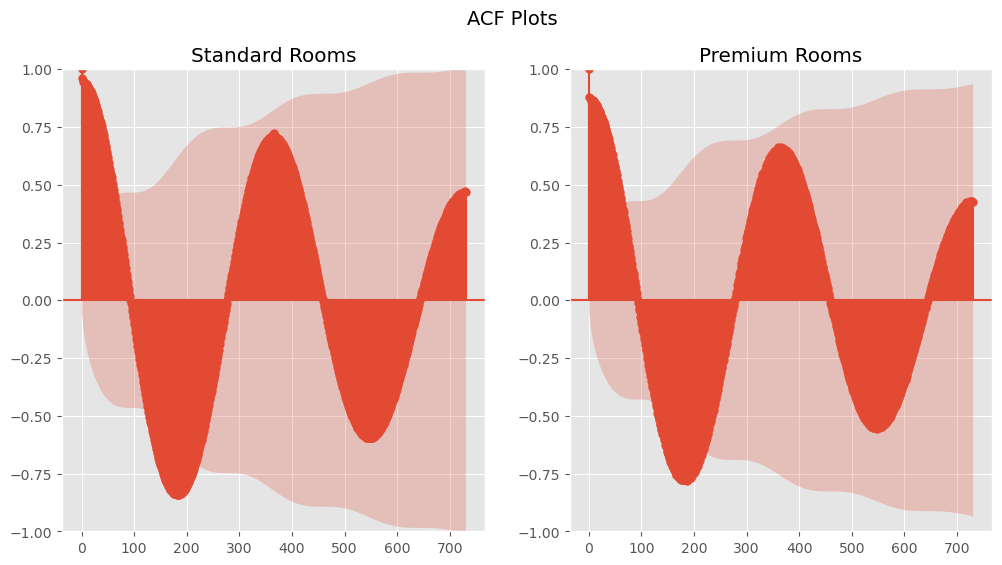

In [12]:
# ACF plot  - is there evidence of seasonality?

lag_value = 730
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('ACF Plots', fontsize=14)

ax1.set_title('Standard Rooms', fontsize=12)
plot_acf(hotel_time_series_df['Standard_OCC'], lags=lag_value, ax=ax1, title='Standard Rooms')
ax2.set_title('Premium Rooms', fontsize=12)
plot_acf(hotel_time_series_df['Premium_OCC'], lags=lag_value, ax=ax2, title='Premium Rooms')

plt.show()


- Both exhibit strong autocorrelation that diminishes slowly after approximately 250 days
- A positive trend is suggested by the slowly diminishing autocorrelation
- Multiple peaks at 350 days indicates annual seasonality
- ?? carry out PACF to determine the autoregressive order .... does indicate that it is autoregressive


In [13]:
# Is there evidence of stationarity?

# Augmented Dickey-Fuller (ADF) test
print(f'ADF Test for Standard Rooms')
adf_result = adfuller(hotel_time_series_df['Standard_OCC'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')
print('Conclusion:', 'Stationary' if adf_result[1] < 0.05 else 'Non-Stationary', "\n")

print(f'ADF Test for Premium Rooms')
adf_result = adfuller(hotel_time_series_df['Premium_OCC'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')
print('Conclusion:', 'Stationary' if adf_result[1] < 0.05 else 'Non-Stationary', "\n")


ADF Test for Standard Rooms
ADF Statistic: -2.362457191578427
p-value: 0.15261408046089647
Critical Value 1%: -3.434908816804013
Critical Value 5%: -2.863553406963303
Critical Value 10%: -2.5678419239852994
Conclusion: Non-Stationary 

ADF Test for Premium Rooms
ADF Statistic: -2.1359470749871265
p-value: 0.2303078418058474
Critical Value 1%: -3.434911997169608
Critical Value 5%: -2.863554810504947
Critical Value 10%: -2.567842671398422
Conclusion: Non-Stationary 



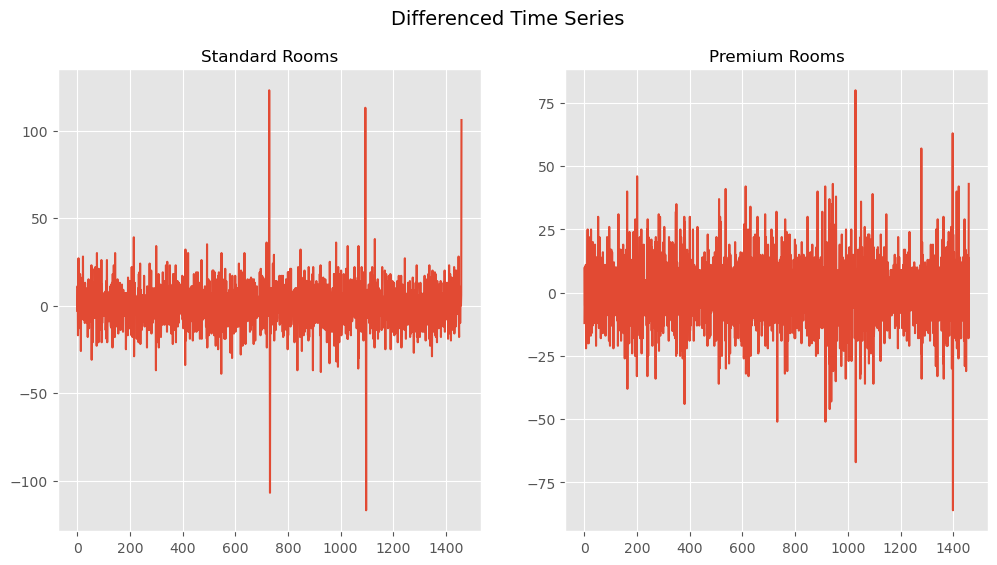

ADF Test for Standard Rooms
ADF Statistic: -4.650429185341465
p-value: 0.00010417359492157454
Critical Value 1%: -3.4349151819757466
Critical Value 5%: -2.863556216004778
Critical Value 10%: -2.5678434198545568
Conclusion: Stationary 

ADF Test for Premium Rooms
ADF Statistic: -6.091009300062941
p-value: 1.0365104637060615e-07
Critical Value 1%: -3.4349151819757466
Critical Value 5%: -2.863556216004778
Critical Value 10%: -2.5678434198545568
Conclusion: Stationary 



In [14]:
# Perform differencing to confirm non-stationary

differenced_series_std = np.diff(hotel_time_series_df['Standard_OCC'])
differenced_series_prm = np.diff(hotel_time_series_df['Premium_OCC'])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Differenced Time Series', fontsize=14)

ax1.set_title('Standard Rooms', fontsize=12)
ax1.plot(differenced_series_std)
ax2.set_title('Premium Rooms', fontsize=12)
ax2.plot(differenced_series_prm)

plt.show()

# Repeat ADF Test
print(f'ADF Test for Standard Rooms')
adf_result = adfuller(differenced_series_std)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')
print('Conclusion:', 'Stationary' if adf_result[1] < 0.05 else 'Non-Stationary', "\n")

print(f'ADF Test for Premium Rooms')
adf_result = adfuller(differenced_series_prm)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')
print('Conclusion:', 'Stationary' if adf_result[1] < 0.05 else 'Non-Stationary', "\n")

- Confirms that both time series are non-stationary

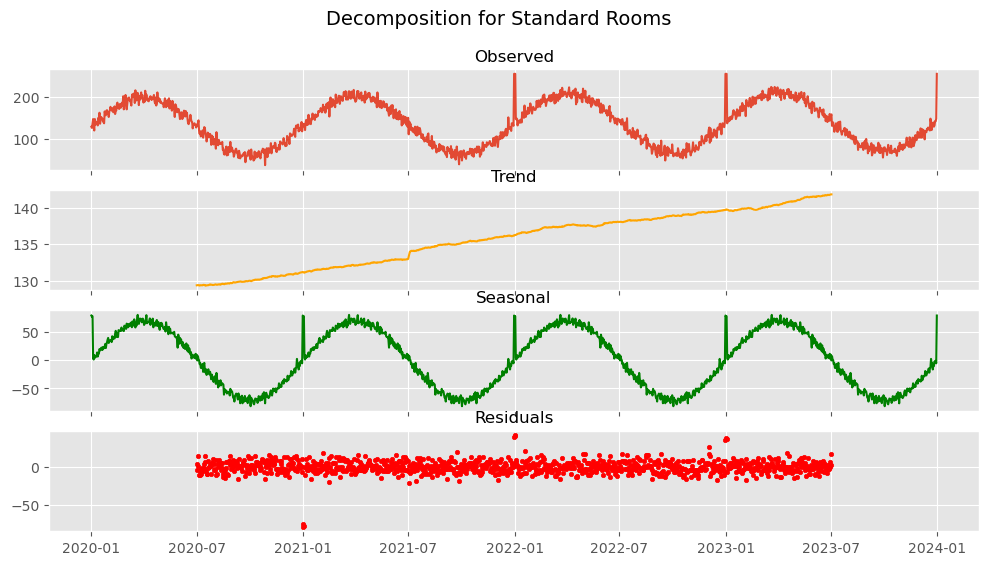

In [29]:
#| label: decomposition
#| fig-cap: Occupancy Time Series Decomposition

# Perform decomposition

def decompose_time_series(series, title):
    # Perform decomposition
    decomposition = seasonal_decompose(series, model='additive', period=365)

    # Plot the decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(12, 6), sharex=True)
    fig.suptitle(f'Decomposition for {title}', fontsize=14)

    ax1.set_title('Observed', fontsize=12)
    ax1.plot(decomposition.observed, label='Observed')
    ax2.set_title('Trend', fontsize=12)
    ax2.plot(decomposition.trend, label='Trend', color='orange')
    ax3.set_title('Seasonal', fontsize=12)
    ax3.plot(decomposition.seasonal, label='Seasonal', color='green')
    ax4.set_title('Residuals', fontsize=12)
    #ax4.plot(decomposition.resid, label='Residuals', color='red')
    ax4.scatter(decomposition.resid.index, decomposition.resid, label='Residuals', color='red', s=10)

    plt.show()

# Decompose - Standard Rooms
decompose_time_series(hotel_time_series_df['Standard_OCC'], 'Standard Rooms')


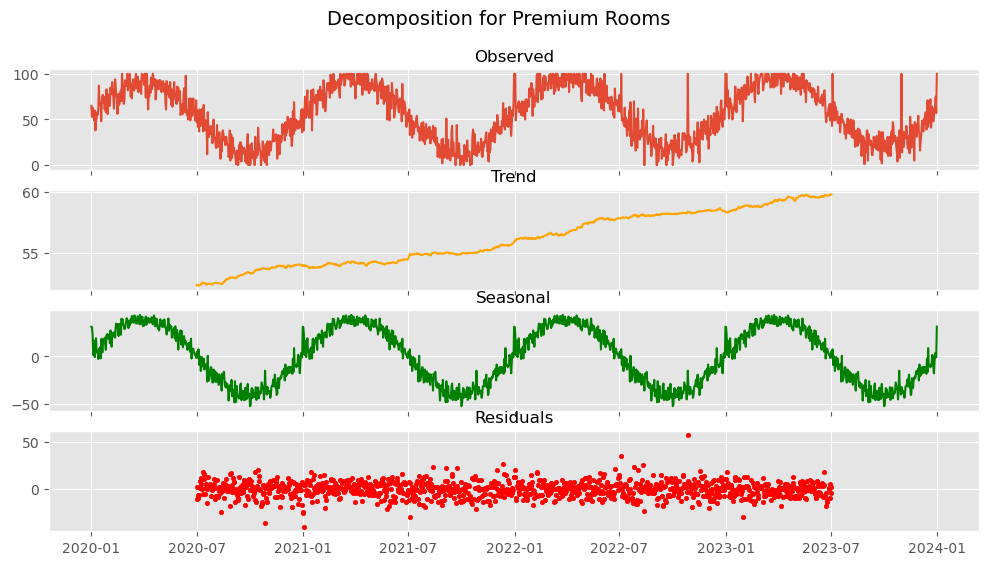

In [31]:
#| label: decomposition-prem
#| fig-cap: Occupancy Time Series Decomposition

# Decompose - Premium Rooms
decompose_time_series(hotel_time_series_df['Premium_OCC'], 'Premium Rooms')

- Both have a small positive trend with room occupancy increasing 5 to 105% pa
- Confirms both time series are seasonal, with annual peaks and troughs
- On top of the annual seasonality, there are regular spikes leading to 100% occupancy
- Close clustering of residuals with some outliers that correspond to the seasonal spikes


## Ordinary Least Squares (OLS) Linear Regression 

- Unlikely to be a good model for forecasting given the strong seasonality, but examine to confirm

In [16]:
# Fit a linear regression model

# Standard Rooms
x = add_constant(hotel_time_series_df.index.factorize()[0])
y = hotel_time_series_df['Standard_OCC']
model = OLS(y, x).fit()
dw_stat = durbin_watson(model.resid)
print("Durbin-Watson statistic:", dw_stat)

# Premium Rooms
y_premium = hotel_time_series_df['Premium_OCC']
model_premium = OLS(y_premium, x).fit()
dw_stat = durbin_watson(model_premium.resid)
print("Durbin-Watson statistic:", dw_stat)

#

Durbin-Watson statistic: 0.07265854622866856
Durbin-Watson statistic: 0.24391749000237792


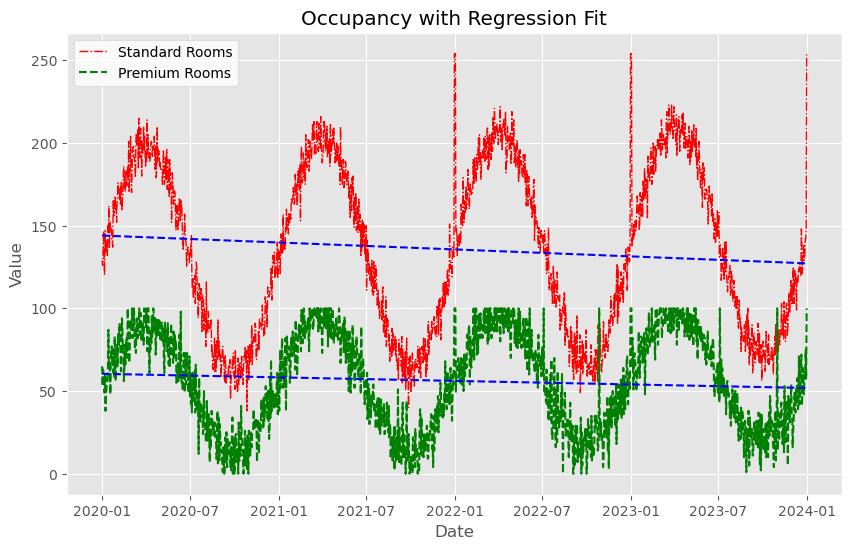

In [18]:
#| label: olsregression
#| fig-cap: OLS Linear Regression

# Plot the occupancy time series data + regression fit line
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title(f'Occupancy with Regression Fit')
ax.set_xlabel('Date')
ax.set_ylabel('Value')

# Two line plots
ax.plot(hotel_time_series_df.index, hotel_time_series_df['Standard_OCC'], linestyle='-.', color='red', linewidth=1, label='Standard Rooms')
plt.plot(hotel_time_series_df.index, model.fittedvalues, color='blue', linestyle='--')

ax.plot(hotel_time_series_df.index, hotel_time_series_df['Premium_OCC'], 'g--', label='Premium Rooms')
plt.plot(hotel_time_series_df.index, model_premium.fittedvalues, color='blue', linestyle='--')

# Legend
ax.legend(loc='upper left', facecolor='white')
plt.show()

- The two fitted lines do not capture any seasonality
- Also show a downward trend line, which is not consistent with the decomposition trend line
- The Durban Watson statistics for both time series are less than 1.5 which confirms evidence of autocorrelation